## Setup

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os

NEG_DIRECTORY_PATH = './review_polarity/txt_sentoken/neg'
POS_DIRECTORY_PATH = './review_polarity/txt_sentoken/pos'

## Load Text Data

1. iterate through negative and positive text files

2. concat all lines per file to a single string

3. create tensor dataset from list of strings

4. label tensor dataset with 0 - negative | 1 - positive

In [2]:
labeled_data_sets = []

neg_file_names = list(os.listdir(NEG_DIRECTORY_PATH))
pos_file_names = list(os.listdir(POS_DIRECTORY_PATH))

all_lines_list = []
neg_lines_list = []
for file_name in neg_file_names:
  file = open(os.path.join(NEG_DIRECTORY_PATH, file_name))
  lines = ''
  for line in file:
    lines += line.rstrip() + ' '
  neg_lines_list.append(lines)
  all_lines_list.append(lines)
  file.close()

lines_dataset = tf.data.Dataset.from_tensor_slices(neg_lines_list)
labeled_data_set = lines_dataset.map(lambda ex: (ex, 0))
labeled_data_sets.append(labeled_data_set)

pos_lines_list = []
for file_name in pos_file_names:
  file = open(os.path.join(POS_DIRECTORY_PATH, file_name))
  lines = ''
  for line in file:
    lines += line.rstrip() + ' '
  pos_lines_list.append(lines)
  all_lines_list.append(lines)
  file.close()

lines_dataset = tf.data.Dataset.from_tensor_slices(pos_lines_list)
labeled_data_set = lines_dataset.map(lambda ex: (ex, 1))
labeled_data_sets.append(labeled_data_set)

## Prepare Data

1. Concat positive and negative reviews
2. Double check size of full dataset
3. Shuffle data

In [3]:
BUFFER_SIZE = 1000

neg_labeled_data = labeled_data_sets[0]
pos_labeled_data = labeled_data_sets[1]
print("Negative labeled data len:", len(list(neg_labeled_data)))
print("Negative data len:", len(neg_file_names))
print("Positive labeled data len:", len(list(pos_labeled_data)))
print("Positive data len:", len(pos_file_names))

pos_labeled_data = pos_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)
neg_labeled_data = neg_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

Negative labeled data len: 1000
Negative data len: 1000
Positive labeled data len: 1000
Positive data len: 1000


## Data Exploration

# Samples: 2000
Median num words per sample: 696.5


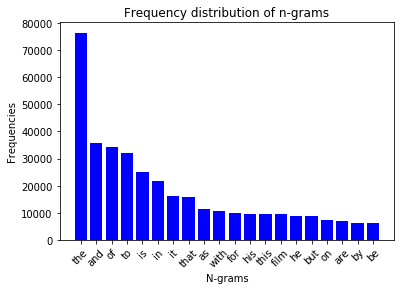

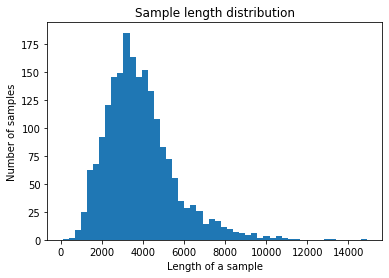

In [4]:
import explore_data as ed

print("# Samples:", len(all_lines_list))
print("Median num words per sample:", ed.get_num_words_per_sample(all_lines_list))
ed.plot_frequency_distribution_of_ngrams(all_lines_list,num_ngrams=20)
ed.plot_sample_length_distribution(all_lines_list)

In [5]:
for ex in neg_labeled_data.take(1):
  print(ex)
print("--------------")
for ex in pos_labeled_data.take(1):
  print(ex)

(<tf.Tensor: shape=(), dtype=string, numpy=b'these days the lack of originality in hollywood reflects itself in the deluge of remakes . but , only a few years ago , before wes craven publicly made fun of the practice , sequels had been more popular among hollywood producers . sequels also used to be popular among directors and movie stars whose careers went south . the way to regain popularity and prestige , they thought , was the use the same formulas , characters and story lines that brought them success in the first place . one of such celebrity was eddie murphy , black comedian of 1980s whose career was in big decline during the first part of this decade . in order to return to the spotlight , he chose to resurrect the franchise created by his most popular film , beverly hills cop , 1984 action comedy that had already spawned the sequel in 1987 . seven years later , for the third instalment , he used the directorial service of john landis , another fading star , with whom he succes

## Tokenize and Encode Words

1. Get unique vocabulary set among data
2. Create encoder based on vocabulary set
3. Encode data text -> int using vocabulary as dictionary

In [6]:
tokenizer = tfds.features.text.Tokenizer()

vocabulary_set = set()
for text_tensor, _ in neg_labeled_data:
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

for text_tensor, _ in pos_labeled_data:
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size

39696

In [7]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [8]:
example_text = next(iter(pos_labeled_data))[0].numpy()
print(example_text)

b'the coen brothers are back again , this time with homer\'s " odyssey " as the backdrop in their tale of three fugitives from a mississippi chain gang who trek across the south to find a secret treasure in " o brother , where art thou ? " right for the beginning of " o brother " the coens grab your attention with a chain gang of prison inmates breaking rocks along the road in unison to a work song . the camera flows around the hard toiling men , giving a visually exciting symmetry to the scene that ends with our three heroes - ulysses everett mcgill ( george clooney ) , delmar ( tim blake nelson ) and pete ( john turturro ) - escaping across a cotton field . it is the beginning of a journey that takes on different meanings and urgencies to each member of the trio . a strong suite , as always with the coen brothers , is the depth of character of the folks they create in their films . their characters are goofy and comical , like nicolas cage in " raising arizona " ; or , dramatic , as 

In [9]:
encoded_example = encoder.encode(example_text)
print(encoded_example)

[38259, 31858, 21312, 8305, 26481, 34855, 30350, 12691, 25148, 10605, 36819, 14673, 32058, 38259, 26913, 12258, 22996, 8389, 3762, 36853, 33907, 13332, 8788, 38702, 38596, 30142, 38178, 26620, 32994, 38259, 7090, 34999, 3631, 8788, 5871, 39150, 12258, 22328, 9888, 21907, 22521, 14295, 16569, 8441, 38259, 1365, 3762, 22328, 9888, 38259, 13911, 11424, 26749, 17848, 25148, 8788, 38596, 30142, 3762, 23528, 14681, 11245, 34198, 2712, 38259, 32496, 12258, 5976, 34999, 8788, 23308, 14266, 38259, 36914, 10557, 26774, 38259, 4426, 4126, 17469, 1704, 8788, 252, 7067, 5534, 34999, 38259, 11562, 31960, 31127, 25148, 12180, 36853, 11606, 36746, 37851, 35765, 10083, 2384, 26176, 18226, 39040, 2729, 24622, 22359, 15186, 18835, 15089, 32994, 8788, 26320, 33252, 5728, 28913, 38259, 1365, 3762, 8788, 36145, 31960, 29352, 24639, 30873, 10036, 24622, 33854, 34999, 11750, 7377, 3762, 38259, 3633, 8788, 21489, 5350, 32058, 24046, 25148, 38259, 31858, 21312, 28913, 38259, 10121, 3762, 5136, 3762, 38259, 3501

In [10]:
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

def encode_map_fn(text, label):
  # py_func doesn't set the shape of the returned tensors.
  encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int32))

  return encoded_text, label

In [11]:
pos_encoded_data = pos_labeled_data.map(encode_map_fn)

example_encoding = next(iter(pos_encoded_data))[0].numpy()
print(example_encoding)

neg_encoded_data = neg_labeled_data.map(encode_map_fn)

example_encoding = next(iter(neg_encoded_data))[0].numpy()
print(example_encoding)


[38259 31858 21312  8305 26481 34855 30350 12691 25148 10605 36819 14673
 32058 38259 26913 12258 22996  8389  3762 36853 33907 13332  8788 38702
 38596 30142 38178 26620 32994 38259  7090 34999  3631  8788  5871 39150
 12258 22328  9888 21907 22521 14295 16569  8441 38259  1365  3762 22328
  9888 38259 13911 11424 26749 17848 25148  8788 38596 30142  3762 23528
 14681 11245 34198  2712 38259 32496 12258  5976 34999  8788 23308 14266
 38259 36914 10557 26774 38259  4426  4126 17469  1704  8788   252  7067
  5534 34999 38259 11562 31960 31127 25148 12180 36853 11606 36746 37851
 35765 10083  2384 26176 18226 39040  2729 24622 22359 15186 18835 15089
 32994  8788 26320 33252  5728 28913 38259  1365  3762  8788 36145 31960
 29352 24639 30873 10036 24622 33854 34999 11750  7377  3762 38259  3633
  8788 21489  5350 32058 24046 25148 38259 31858 21312 28913 38259 10121
  3762  5136  3762 38259 35018  2814  5390 12258 22996 17481 22996 38325
  8305 25104 24622 28176  5850 26416 36000 12258 10

## Split Train/Test Data

In [12]:
import math 

TRAIN_AMT = 0.8
BATCH_SIZE = 5

take_size = math.ceil(len(list(neg_encoded_data)) * (1 - TRAIN_AMT))
print(take_size)


200


In [13]:
train_data_pos = pos_encoded_data.skip(take_size).shuffle(BUFFER_SIZE)
train_data_neg = neg_encoded_data.skip(take_size).shuffle(BUFFER_SIZE)

all_labeled_train_data = train_data_pos.concatenate(train_data_neg).shuffle(BUFFER_SIZE * 2)
train_data = all_labeled_train_data.padded_batch(BATCH_SIZE, padded_shapes=([None],[]))

test_data_pos = pos_encoded_data.take(take_size)
test_data_neg = neg_encoded_data.take(take_size)
all_labeled_test_data = test_data_pos.concatenate(test_data_neg).shuffle(BUFFER_SIZE)
test_data = all_labeled_test_data.padded_batch(BATCH_SIZE, padded_shapes=([None],[]))

print(len(list(train_data_pos)) + len(list(train_data_neg)))
print(len(list(test_data_pos)) + len(list(test_data_neg)))
train_data_size = len(list(train_data))
test_data_size = len(list(test_data))
print(train_data_size)
print(test_data_size)

1600
400
320
80


In [14]:
for batch in train_data.take(1):
    print(batch)

(<tf.Tensor: shape=(5, 800), dtype=int64, numpy=
array([[38259, 22877, 27737, ...,     0,     0,     0],
       [20405, 26105, 28913, ...,     0,     0,     0],
       [38259,  2291, 10252, ...,     0,     0,     0],
       [38047, 38259, 13561, ...,  3762, 39385, 36904],
       [27647, 24044, 24622, ...,     0,     0,     0]])>, <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 0, 1], dtype=int32)>)


In [15]:
s_train = set()
for text, labels in train_data:
    s_train.add(labels[0].numpy())
    
s_test = set()
for text, labels in test_data:
    s_test.add(labels[0].numpy())
print(s_train)
print(s_test)


{0, 1}
{0, 1}


In [16]:
sample_text, sample_labels = next(iter(test_data))

print(sample_text)
sample_text[0].numpy(), sample_labels[0].numpy()

tf.Tensor(
[[ 8577 30743 28913 ...     0     0     0]
 [30350 37285 11102 ...     0     0     0]
 [24191  9232  8884 ... 20875 31225 23813]
 [26812 28913  8788 ...     0     0     0]
 [22580 17957 19340 ...     0     0     0]], shape=(5, 720), dtype=int64)


(array([ 8577, 30743, 28913,  8788, 34675,  6517, 18869, 13406,  6825,
        24300,  2572, 24622, 18370,  6154, 31960, 13565, 25148, 18031,
        38259,  8291, 15469,   846,  4701, 24622, 23087, 38259, 20775,
         3762, 38259, 20679, 28913,  8788, 10460, 37696, 17205, 23030,
         5728, 39640,  3762, 22750, 26605, 24622, 21896, 24622, 24639,
        38259,  7286, 24599, 27049, 15203, 32712, 10563, 38259, 10460,
        36819, 30873, 30071, 38259, 20679, 19577,  8407, 20352, 38259,
         1365,  3762,  8788,  5026,  9179,  8984, 38259, 10460, 36819,
        21274,  5981, 23492,  2761,  5728, 28913, 21086, 31960,  6923,
        37298, 18031,  3762, 38259, 36737, 38325,  5982, 36819,  6175,
         5141, 18560, 30426,  2160, 31031, 38202, 16093, 24622,  2162,
         1070, 31332, 25561,  5026, 31470,  9481, 24622, 38259,  3135,
         8344, 23319, 23856, 13037, 18465,  6923,  9403, 26154, 31960,
        18031,  3762, 38259,  5026, 19917,  8305, 28054, 25148, 38259,
      

In [17]:
vocab_size += 1 # we added 0 for the padding

## Word Embeddings

We are going to create 5 word embeddings:

1. Bag of words encoding
2. Manually trained word embedding on data vocabulary set (Continuous bag of words model)
3. Pre-trained Glove 100-dimension embedding
4. Pre-trained Glove 300-dimension embedding
5. Pre-trained Word2Vec embedding

### 1. Bag of words

Here's an example of how we can use tf.one_hot and bitwise or to create a bag of words encoding for our vocab

In [18]:
from tensorflow.python.ops import bitwise_ops
test_vocab = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
test_sentences = [[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9],
                  [0, 5, 1]]
depth = len(test_vocab)

def bitwise_or_multiple(tensors):
    res = tensors[0]
    for i in range(1, len(tensors)):
        res = bitwise_ops.bitwise_or(res, tensors[i])
    
    return res

bag_of_words_list = []
for sentence in tf.one_hot(test_sentences, depth):
    print(sentence)
    bag_of_words_list.append(tf.cast(bitwise_or_multiple(tf.cast(sentence, tf.uint32)), tf.float32))

bag_of_words = tf.stack(bag_of_words_list)
bag_of_words

tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]], shape=(3, 10), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]], shape=(3, 10), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(3, 10), dtype=float32)
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(3, 10), dtype=float32)


<tf.Tensor: shape=(4, 10), dtype=float32, numpy=
array([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [1., 1., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)>

Applying the above to our data

In [19]:
def bag_of_words(d, vocab_size):    
    bow_list = []
    for s in tf.one_hot(d, vocab_size):
        bow_list.append(tf.cast(bitwise_or_multiple(tf.cast(s, tf.uint32))[1:], tf.float32))

    return tf.stack(bow_list)

def bag_of_words_fn(text, labels):
  # py_func doesn't set the shape of the returned tensors.
  encoded_text = tf.py_function(bag_of_words, 
                                       inp=[text, vocab_size], 
                                       Tout=tf.float32)

  return encoded_text, labels


print(bag_of_words(sample_text, vocab_size))

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(5, 39696), dtype=float32)


In [20]:
# NOTE: This takes a while
train_data_bow = train_data.map(bag_of_words_fn)

sample_text_bow, sample_labels_bow = next(iter(train_data_bow))

print(sample_text_bow)
sample_text_bow[0].numpy(), sample_labels_bow[0].numpy()

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(5, 39696), dtype=float32)


(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 1)

In [21]:
test_data_bow = test_data.map(bag_of_words_fn)

sample_text_bow, sample_labels_bow = next(iter(test_data_bow))

print(sample_text_bow)
sample_text_bow[0].numpy(), sample_labels_bow[0].numpy()

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(5, 39696), dtype=float32)


(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 0)

### 2. Manually Trained Word Embedding

In [22]:
embedding_dim=16

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(encoder.vocab_size, embedding_dim),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          635168    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 635,457
Trainable params: 635,457
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_data,
    epochs=10,
    validation_data=test_data)

Epoch 1/15
320/320 [==============================] - 4s 11ms/step - loss: 0.6891 - accuracy: 0.5000 - val_loss: 0.6816 - val_accuracy: 0.5000
Epoch 2/15
320/320 [==============================] - 3s 10ms/step - loss: 0.6460 - accuracy: 0.5281 - val_loss: 0.6111 - val_accuracy: 0.6100
Epoch 3/15
320/320 [==============================] - 3s 10ms/step - loss: 0.4947 - accuracy: 0.7381 - val_loss: 0.4683 - val_accuracy: 0.7975
Epoch 4/15
320/320 [==============================] - 4s 13ms/step - loss: 0.3026 - accuracy: 0.8888 - val_loss: 0.3696 - val_accuracy: 0.8200
Epoch 5/15
320/320 [==============================] - 4s 13ms/step - loss: 0.1778 - accuracy: 0.9419 - val_loss: 0.3328 - val_accuracy: 0.8325
Epoch 6/15
320/320 [==============================] - 4s 12ms/step - loss: 0.1097 - accuracy: 0.9756 - val_loss: 0.3048 - val_accuracy: 0.8350
Epoch 7/15
320/320 [==============================] - 4s 11ms/step - loss: 0.0671 - accuracy: 0.9912 - val_loss: 0.2979 - val_accuracy: 0.8525

In [24]:
e = model.layers[0]
weights_manual = e.get_weights()[0]
print(weights_manual.shape) # shape: (vocab_size, embedding_dim)

print(weights_manual[0])

(39698, 16)
[ 0.06142067  0.0147969  -0.0838063  -0.02944716 -0.03984566  0.0413297
  0.02684033  0.06316119 -0.035011   -0.04558138 -0.05055441  0.05411546
 -0.01372754 -0.11015891 -0.01163573  0.00469563]


### 3. Pre-trained Glove 100-dimension embeddings

In [25]:
import gensim.downloader as api
model_glove100 = api.load("glove-wiki-gigaword-100")
sim = model_glove100.most_similar("shocked")[0]
print(sim)
print(model_glove100[sim[0]])

('stunned', 0.852389395236969)
[ 2.8572e-01 -1.0165e-03  8.6914e-01 -1.2957e-01 -6.5000e-01  8.9016e-01
  2.1256e-01  3.8390e-02  3.1604e-02 -5.7039e-01  1.6348e-01  1.6231e-01
 -1.3964e-01 -8.7294e-01 -5.0476e-01  8.7020e-02 -8.1818e-01  3.2632e-01
 -1.8159e-01 -1.5131e-01  3.6507e-01  5.8848e-01  1.3099e-01  2.3497e-02
  6.4228e-01 -8.8949e-02  3.7893e-01  5.7788e-01  5.3521e-01 -3.1254e-01
  1.4368e-01  1.7315e-01 -1.6229e-01  3.6191e-01 -1.3401e-01 -5.5973e-01
 -3.1169e-01  2.0823e-01  5.2210e-02 -2.4150e-01 -5.6402e-01 -3.9737e-01
  3.2722e-01 -1.9829e-01  3.0287e-01 -1.2222e-01  9.3732e-01  1.0099e+00
  4.0845e-01 -4.3619e-01  5.0938e-02 -7.4795e-01 -1.1002e-01  1.9301e-01
 -4.6331e-01 -1.3785e+00 -5.5050e-01  1.2261e-01  1.7169e-01  2.6167e-01
 -1.3787e-01  2.7178e-01  1.4616e-01 -2.3679e-01 -1.5203e-01 -1.8593e-01
 -2.6488e-02  1.1524e+00 -2.7968e-01  2.0679e-01  1.8962e-01  1.0715e-01
 -2.5267e-01 -1.8774e-01 -5.9221e-02  6.3031e-01  3.7822e-01 -1.8565e-01
 -3.9893e-01 -4.1508

In [26]:
import numpy as np
from nltk.stem.porter import PorterStemmer

def get_embedding_matrix(model, dim):
    stemmer = PorterStemmer()
    count = 0
    embedding_matrix = np.zeros((encoder.vocab_size, dim))
    for i, word in enumerate(vocabulary_set):
        try:
            embedding_vector = model[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            try:
                stem = stemmer.stem(word)
                embedding_matrix[i] = model[stem]
            except KeyError:
                try: 
                    sim = model.most_similar(stem)[0]
                    print(word, sim)
                    embedding_matrix[i] = model[sim]
                except KeyError: 
                    count +=1
                    embedding_matrix[i] = np.zeros(dim)        
    print(count)
    print(embedding_matrix.shape)
    print(encoder.vocab_size)
    return embedding_matrix

In [27]:
embedding_matrix_glove100 = get_embedding_matrix(model_glove100, 100)

2963
(39698, 100)
39698


### 4. Pre-trained Glove 300-dimension embeddings

In [28]:
model_glove300 = api.load("glove-wiki-gigaword-300")
embedding_matrix_glove300 = get_embedding_matrix(model_glove300, 300)

2963
(39698, 300)
39698


### 5. Pre-trained Word2Vec embeddings

In [29]:
model_word2vec = api.load("word2vec-google-news-300")
embedding_matric_word2vec = get_embedding_matrix(model_word2vec, 300)

7402
(39698, 300)
39698


## Create Model and Tune Hyperparameters

In [30]:
def train_model(train_data, test_data, filters = 64, kernel_size = 5, dropout_rate = 0, embedding_dim=16, weights=np.zeros((encoder.vocab_size, 16))) -> {str: float}:
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Embedding(input_dim=encoder.vocab_size, 
                                        output_dim=embedding_dim, 
                                        weights=[weights],
                                        mask_zero=True,
                                        trainable=False))
#     for _ in range(blocks-1):
        #model.add(tf.keras.layers.Dropout(rate=dropout_rate))
#         model.add(tf.keras.layers.Conv1D(filters=filters,
#                                   kernel_size=kernel_size,
#                                   activation='relu',
#                                   #bias_initializer='random_uniform',
#                                   #depthwise_initializer='random_uniform',
#                                   #padding='same'
#                                         ))
#         model.add(tf.keras.layers.Conv1D(filters=filters,
#                                   kernel_size=kernel_size,
#                                   activation='relu',
#                                   #bias_initializer='random_uniform',
#                                   #depthwise_initializer='random_uniform',
#                                   #padding='same'
#                                         ))
#         model.add(tf.keras.layers.MaxPooling1D(pool_size=pool_size))

#     model.add(tf.keras.layers.Conv1D(filters=filters * 2,
#                               kernel_size=kernel_size,
#                               activation='relu',
#                               #bias_initializer='random_uniform',
#                               #depthwise_initializer='random_uniform',
#                               #padding='same'
#                                     ))
    model.add(tf.keras.layers.Conv1D(filters=filters,
                              kernel_size=kernel_size,
                              activation='relu',
                                    ))
    
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    
    
    # Compile and train model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.fit(train_data, epochs=10, validation_data=test_data)
    eval_loss, eval_acc = model.evaluate(test_data)

    print('\nEval loss: {:.3f}, Eval accuracy: {:.3f}'.format(eval_loss, eval_acc))
    
    return { 
        "filters": filters,
        "kernel_size": kernel_size,
        "dropout_rate": dropout_rate,
        "loss": eval_loss,
        "accuracy": eval_acc
    }

In [31]:
filter_size_results_g100 = [train_model(train_data, test_data, filters=x, embedding_dim = 100, weights=embedding_matrix_glove100) for x in [2*x for x in range(1, 10)]]
kernel_size_results_g100 = [train_model(train_data, test_data, kernel_size=x, embedding_dim = 100, weights=embedding_matrix_glove100) for x in range(1, 11)]
dropout_rate_results_g100 = [train_model(train_data, test_data, dropout_rate=(x/10.0), embedding_dim = 100, weights=embedding_matrix_glove100) for x in range(1, 10)]



Epoch 1/10
320/320 [==============================] - 9s 29ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/10
320/320 [==============================] - 5s 16ms/step - loss: 0.6923 - accuracy: 0.5000 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 3/10
320/320 [==============================] - 14s 45ms/step - loss: 0.6895 - accuracy: 0.5000 - val_loss: 0.6862 - val_accuracy: 0.5000
Epoch 4/10
320/320 [==============================] - 6s 17ms/step - loss: 0.6848 - accuracy: 0.5000 - val_loss: 0.6784 - val_accuracy: 0.5050
Epoch 5/10
320/320 [==============================] - 5s 17ms/step - loss: 0.6778 - accuracy: 0.5088 - val_loss: 0.6726 - val_accuracy: 0.5100
Epoch 6/10
320/320 [==============================] - 7s 21ms/step - loss: 0.6707 - accuracy: 0.5206 - val_loss: 0.6625 - val_accuracy: 0.5050
Epoch 7/10
320/320 [==============================] - 6s 18ms/step - loss: 0.6587 - accuracy: 0.5594 - val_loss: 0.6546 - val_accuracy: 0.535

Epoch 4/10
320/320 [==============================] - 11s 33ms/step - loss: 0.6746 - accuracy: 0.5362 - val_loss: 0.6657 - val_accuracy: 0.5475
Epoch 5/10
320/320 [==============================] - 11s 36ms/step - loss: 0.6655 - accuracy: 0.5612 - val_loss: 0.6472 - val_accuracy: 0.5500
Epoch 6/10
320/320 [==============================] - 12s 38ms/step - loss: 0.6418 - accuracy: 0.5913 - val_loss: 0.6426 - val_accuracy: 0.5275
Epoch 7/10
320/320 [==============================] - 8s 25ms/step - loss: 0.6300 - accuracy: 0.6150 - val_loss: 0.6193 - val_accuracy: 0.6050
Epoch 8/10
320/320 [==============================] - 11s 35ms/step - loss: 0.6140 - accuracy: 0.6325 - val_loss: 0.6118 - val_accuracy: 0.6500
Epoch 9/10
320/320 [==============================] - 9s 28ms/step - loss: 0.6004 - accuracy: 0.6513 - val_loss: 0.5984 - val_accuracy: 0.6500
Epoch 10/10
80/80 [==============================] - 1s 6ms/step - loss: 0.6078 - accuracy: 0.6200

Eval loss: 0.608, Eval accuracy: 0.620

Epoch 7/10
320/320 [==============================] - 6s 20ms/step - loss: 0.6222 - accuracy: 0.6181 - val_loss: 0.6690 - val_accuracy: 0.5200
Epoch 8/10
320/320 [==============================] - 5s 15ms/step - loss: 0.6160 - accuracy: 0.6225 - val_loss: 0.6066 - val_accuracy: 0.6050
Epoch 9/10
320/320 [==============================] - 5s 16ms/step - loss: 0.6033 - accuracy: 0.6338 - val_loss: 0.6022 - val_accuracy: 0.6150
Epoch 10/10
80/80 [==============================] - 0s 6ms/step - loss: 0.5937 - accuracy: 0.6300

Eval loss: 0.594, Eval accuracy: 0.630
Epoch 1/10
320/320 [==============================] - 6s 20ms/step - loss: 0.6906 - accuracy: 0.5094 - val_loss: 0.6917 - val_accuracy: 0.5075
Epoch 2/10
320/320 [==============================] - 6s 19ms/step - loss: 0.6872 - accuracy: 0.5063 - val_loss: 0.6812 - val_accuracy: 0.5525
Epoch 3/10
320/320 [==============================] - 6s 20ms/step - loss: 0.6757 - accuracy: 0.5394 - val_loss: 0.6670 - val_accuracy: 0.5225
Epo

320/320 [==============================] - 2079s 6s/step - loss: 0.5701 - accuracy: 0.6687 - val_loss: 0.5944 - val_accuracy: 0.6300
Epoch 10/10
80/80 [==============================] - 1s 11ms/step - loss: 0.5816 - accuracy: 0.6600

Eval loss: 0.582, Eval accuracy: 0.660
Epoch 1/10
320/320 [==============================] - 11s 34ms/step - loss: 0.6912 - accuracy: 0.5050 - val_loss: 0.6734 - val_accuracy: 0.5125
Epoch 2/10
320/320 [==============================] - 11s 33ms/step - loss: 0.6779 - accuracy: 0.5312 - val_loss: 0.6590 - val_accuracy: 0.6100
Epoch 3/10
320/320 [==============================] - 11s 35ms/step - loss: 0.6580 - accuracy: 0.5675 - val_loss: 0.6427 - val_accuracy: 0.6100
Epoch 4/10
320/320 [==============================] - 12s 36ms/step - loss: 0.6434 - accuracy: 0.5981 - val_loss: 0.6229 - val_accuracy: 0.6150
Epoch 5/10
320/320 [==============================] - 11s 33ms/step - loss: 0.6241 - accuracy: 0.6062 - val_loss: 0.6159 - val_accuracy: 0.5925
Epoch 6

Epoch 1/10
320/320 [==============================] - 8s 26ms/step - loss: 0.6958 - accuracy: 0.4994 - val_loss: 0.6860 - val_accuracy: 0.5000
Epoch 2/10
320/320 [==============================] - 9s 27ms/step - loss: 0.6872 - accuracy: 0.5256 - val_loss: 0.6767 - val_accuracy: 0.5150
Epoch 3/10
320/320 [==============================] - 9s 28ms/step - loss: 0.6842 - accuracy: 0.5325 - val_loss: 0.6789 - val_accuracy: 0.5950
Epoch 4/10
320/320 [==============================] - 9s 27ms/step - loss: 0.6717 - accuracy: 0.5425 - val_loss: 0.6591 - val_accuracy: 0.5625
Epoch 5/10
320/320 [==============================] - 9s 28ms/step - loss: 0.6690 - accuracy: 0.5456 - val_loss: 0.6471 - val_accuracy: 0.5300
Epoch 6/10
320/320 [==============================] - 8s 25ms/step - loss: 0.6576 - accuracy: 0.5794 - val_loss: 0.6336 - val_accuracy: 0.5550
Epoch 7/10
320/320 [==============================] - 9s 27ms/step - loss: 0.6439 - accuracy: 0.5919 - val_loss: 0.6521 - val_accuracy: 0.5200

Epoch 4/10
320/320 [==============================] - 7s 22ms/step - loss: 0.6940 - accuracy: 0.5063 - val_loss: 0.6894 - val_accuracy: 0.5000
Epoch 5/10
320/320 [==============================] - 9s 28ms/step - loss: 0.6909 - accuracy: 0.5038 - val_loss: 0.6870 - val_accuracy: 0.5000
Epoch 6/10
320/320 [==============================] - 12s 37ms/step - loss: 0.6858 - accuracy: 0.5169 - val_loss: 0.6853 - val_accuracy: 0.5000
Epoch 7/10
320/320 [==============================] - 6s 20ms/step - loss: 0.6910 - accuracy: 0.5231 - val_loss: 0.6894 - val_accuracy: 0.5000
Epoch 8/10
320/320 [==============================] - 7s 21ms/step - loss: 0.6875 - accuracy: 0.5175 - val_loss: 0.6836 - val_accuracy: 0.5000
Epoch 9/10
320/320 [==============================] - 9s 29ms/step - loss: 0.6834 - accuracy: 0.5288 - val_loss: 0.6819 - val_accuracy: 0.5000
Epoch 10/10
80/80 [==============================] - 1s 7ms/step - loss: 0.6812 - accuracy: 0.5000: 0s - loss: 0.6817 - accuracy

Eval loss: 

In [32]:
filter_size_results_manual = [train_model(train_data, test_data, filters=x, embedding_dim = 16, weights=weights_manual) for x in [2*x for x in range(1, 10)]]
kernel_size_results_manual = [train_model(train_data, test_data, kernel_size=x, embedding_dim = 16, weights=weights_manual) for x in range(1, 11)]
dropout_rate_results_manual = [train_model(train_data, test_data, dropout_rate=(x/10.0), embedding_dim = 16, weights=weights_manual) for x in range(1, 10)]

Epoch 1/10
320/320 [==============================] - 2s 8ms/step - loss: 0.6269 - accuracy: 0.6131 - val_loss: 0.5952 - val_accuracy: 0.7525
Epoch 2/10
320/320 [==============================] - 4s 12ms/step - loss: 0.3371 - accuracy: 0.9731 - val_loss: 0.3995 - val_accuracy: 0.8350
Epoch 3/10
320/320 [==============================] - 3s 8ms/step - loss: 0.1129 - accuracy: 0.9994 - val_loss: 0.3196 - val_accuracy: 0.8575
Epoch 4/10
320/320 [==============================] - 5s 16ms/step - loss: 0.0465 - accuracy: 1.0000 - val_loss: 0.3055 - val_accuracy: 0.8650
Epoch 5/10
320/320 [==============================] - 2s 7ms/step - loss: 0.0241 - accuracy: 1.0000 - val_loss: 0.3071 - val_accuracy: 0.8725
Epoch 6/10
320/320 [==============================] - 2s 7ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.3073 - val_accuracy: 0.8800
Epoch 7/10
320/320 [==============================] - 2s 7ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.3186 - val_accuracy: 0.8850
Epoc

320/320 [==============================] - 2s 8ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.3505 - val_accuracy: 0.8875
Epoch 5/10
320/320 [==============================] - 2s 7ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.3510 - val_accuracy: 0.8650
Epoch 6/10
320/320 [==============================] - 3s 8ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.3698 - val_accuracy: 0.8825
Epoch 7/10
320/320 [==============================] - 2s 8ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4034 - val_accuracy: 0.8725
Epoch 8/10
320/320 [==============================] - 3s 8ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.4083 - val_accuracy: 0.8875
Epoch 9/10
320/320 [==============================] - 3s 8ms/step - loss: 8.5582e-04 - accuracy: 1.0000 - val_loss: 0.4507 - val_accuracy: 0.8775
Epoch 10/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4441 - accuracy: 0.8900

Eval loss: 0.444, Eval accuracy: 0.890
Epoch 1/10
320/3

Epoch 7/10
320/320 [==============================] - 3s 8ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.4167 - val_accuracy: 0.8875
Epoch 8/10
320/320 [==============================] - 3s 8ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4368 - val_accuracy: 0.8750
Epoch 9/10
320/320 [==============================] - 3s 8ms/step - loss: 8.9187e-04 - accuracy: 1.0000 - val_loss: 0.4352 - val_accuracy: 0.8925
Epoch 10/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4351 - accuracy: 0.8725

Eval loss: 0.435, Eval accuracy: 0.873
Epoch 1/10
320/320 [==============================] - 3s 9ms/step - loss: 0.3536 - accuracy: 0.8175 - val_loss: 0.3126 - val_accuracy: 0.8550
Epoch 2/10
320/320 [==============================] - 3s 9ms/step - loss: 0.0265 - accuracy: 1.0000 - val_loss: 0.3228 - val_accuracy: 0.8825
Epoch 3/10
320/320 [==============================] - 3s 8ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.3126 - val_accuracy: 0.8725
Epoch

320/320 [==============================] - 3s 10ms/step - loss: 1.9575e-04 - accuracy: 1.0000 - val_loss: 0.6133 - val_accuracy: 0.8900
Epoch 10/10
80/80 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.8950

Eval loss: 0.645, Eval accuracy: 0.895
Epoch 1/10
320/320 [==============================] - 4s 12ms/step - loss: 0.2202 - accuracy: 0.9181 - val_loss: 0.3080 - val_accuracy: 0.8700
Epoch 2/10
320/320 [==============================] - 4s 12ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.3446 - val_accuracy: 0.8800
Epoch 3/10
320/320 [==============================] - 8s 25ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.3732 - val_accuracy: 0.8875
Epoch 4/10
320/320 [==============================] - 4s 12ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4053 - val_accuracy: 0.8700
Epoch 5/10
320/320 [==============================] - 4s 13ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.4422 - val_accuracy: 0.8875
Epoch 6/10

80/80 [==============================] - 0s 3ms/step - loss: 0.5407 - accuracy: 0.8750

Eval loss: 0.541, Eval accuracy: 0.875
Epoch 1/10
320/320 [==============================] - 3s 10ms/step - loss: 0.2937 - accuracy: 0.8469 - val_loss: 0.2985 - val_accuracy: 0.8650
Epoch 2/10
320/320 [==============================] - 3s 9ms/step - loss: 0.0232 - accuracy: 0.9994 - val_loss: 0.3413 - val_accuracy: 0.8750
Epoch 3/10
320/320 [==============================] - 3s 9ms/step - loss: 0.0110 - accuracy: 0.9981 - val_loss: 0.3448 - val_accuracy: 0.8750
Epoch 4/10
320/320 [==============================] - 3s 9ms/step - loss: 0.0067 - accuracy: 0.9987 - val_loss: 0.4050 - val_accuracy: 0.8850
Epoch 5/10
320/320 [==============================] - 3s 9ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.4293 - val_accuracy: 0.8825
Epoch 6/10
320/320 [==============================] - 3s 11ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.4017 - val_accuracy: 0.8825
Epoch 7/10
320/320 

320/320 [==============================] - 3s 9ms/step - loss: 0.1916 - accuracy: 0.9225 - val_loss: 0.2942 - val_accuracy: 0.8750
Epoch 4/10
320/320 [==============================] - 3s 9ms/step - loss: 0.1394 - accuracy: 0.9531 - val_loss: 0.2951 - val_accuracy: 0.8775
Epoch 5/10
320/320 [==============================] - 3s 9ms/step - loss: 0.1625 - accuracy: 0.9362 - val_loss: 0.2838 - val_accuracy: 0.8675
Epoch 6/10
320/320 [==============================] - 3s 10ms/step - loss: 0.1122 - accuracy: 0.9538 - val_loss: 0.2871 - val_accuracy: 0.8625
Epoch 7/10
320/320 [==============================] - 3s 10ms/step - loss: 0.1361 - accuracy: 0.9556 - val_loss: 0.2938 - val_accuracy: 0.8700
Epoch 8/10
320/320 [==============================] - 3s 9ms/step - loss: 0.1264 - accuracy: 0.9550 - val_loss: 0.3111 - val_accuracy: 0.8825
Epoch 9/10
320/320 [==============================] - 3s 9ms/step - loss: 0.1244 - accuracy: 0.9556 - val_loss: 0.2844 - val_accuracy: 0.8800
Epoch 10/10
80/

In [33]:
filter_size_results_g300 = [train_model(train_data, test_data, filters=x, embedding_dim = 300, weights=embedding_matrix_glove300) for x in [2*x for x in range(1, 10)]]
kernel_size_results_g300 = [train_model(train_data, test_data, kernel_size=x, embedding_dim = 300, weights=embedding_matrix_glove300) for x in range(1, 11)]
dropout_rate_results_g300 = [train_model(train_data, test_data, dropout_rate=(x/10.0), embedding_dim = 300, weights=embedding_matrix_glove300) for x in range(1, 10)]

Epoch 1/10
320/320 [==============================] - 10s 32ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
320/320 [==============================] - 9s 27ms/step - loss: 0.6908 - accuracy: 0.5000 - val_loss: 0.6873 - val_accuracy: 0.5000
Epoch 3/10
320/320 [==============================] - 10s 33ms/step - loss: 0.6785 - accuracy: 0.5094 - val_loss: 0.6625 - val_accuracy: 0.5950
Epoch 4/10
320/320 [==============================] - 13s 41ms/step - loss: 0.6376 - accuracy: 0.5938 - val_loss: 0.6138 - val_accuracy: 0.6675
Epoch 5/10
320/320 [==============================] - 8s 26ms/step - loss: 0.6058 - accuracy: 0.6363 - val_loss: 0.5923 - val_accuracy: 0.6525
Epoch 6/10
320/320 [==============================] - 8s 26ms/step - loss: 0.5842 - accuracy: 0.6562 - val_loss: 0.6017 - val_accuracy: 0.7125
Epoch 7/10
320/320 [==============================] - 10s 32ms/step - loss: 0.5709 - accuracy: 0.6775 - val_loss: 0.5980 - val_accuracy: 0.

320/320 [==============================] - 16s 49ms/step - loss: 0.6816 - accuracy: 0.5094 - val_loss: 0.6846 - val_accuracy: 0.6050
Epoch 4/10
320/320 [==============================] - 11s 33ms/step - loss: 0.6650 - accuracy: 0.5544 - val_loss: 0.6486 - val_accuracy: 0.5975
Epoch 5/10
320/320 [==============================] - 14s 43ms/step - loss: 0.6345 - accuracy: 0.6019 - val_loss: 0.6086 - val_accuracy: 0.6175
Epoch 6/10
320/320 [==============================] - 16s 51ms/step - loss: 0.6076 - accuracy: 0.6269 - val_loss: 0.5960 - val_accuracy: 0.6175
Epoch 7/10
320/320 [==============================] - 11s 33ms/step - loss: 0.5844 - accuracy: 0.6606 - val_loss: 0.6056 - val_accuracy: 0.6900
Epoch 8/10
320/320 [==============================] - 14s 45ms/step - loss: 0.5677 - accuracy: 0.6856 - val_loss: 0.5663 - val_accuracy: 0.6850
Epoch 9/10
320/320 [==============================] - 13s 42ms/step - loss: 0.5458 - accuracy: 0.6906 - val_loss: 0.5507 - val_accuracy: 0.6875
Epo

320/320 [==============================] - 8s 25ms/step - loss: 0.5953 - accuracy: 0.6531 - val_loss: 0.5803 - val_accuracy: 0.6250
Epoch 6/10
320/320 [==============================] - 10s 31ms/step - loss: 0.5686 - accuracy: 0.6737 - val_loss: 0.5795 - val_accuracy: 0.6000
Epoch 7/10
320/320 [==============================] - 10s 32ms/step - loss: 0.5459 - accuracy: 0.6994 - val_loss: 0.5407 - val_accuracy: 0.7150
Epoch 8/10
320/320 [==============================] - 10s 32ms/step - loss: 0.5285 - accuracy: 0.7094 - val_loss: 0.5392 - val_accuracy: 0.6625
Epoch 9/10
320/320 [==============================] - 8s 26ms/step - loss: 0.5048 - accuracy: 0.7231 - val_loss: 0.5224 - val_accuracy: 0.6850
Epoch 10/10
80/80 [==============================] - 1s 9ms/step - loss: 0.4991 - accuracy: 0.7100

Eval loss: 0.499, Eval accuracy: 0.710
Epoch 1/10
320/320 [==============================] - 17s 54ms/step - loss: 0.6932 - accuracy: 0.5088 - val_loss: 0.6862 - val_accuracy: 0.5000
Epoch 2/10

320/320 [==============================] - 33s 104ms/step - loss: 0.4868 - accuracy: 0.7475 - val_loss: 0.5385 - val_accuracy: 0.7550
Epoch 8/10
320/320 [==============================] - 29s 90ms/step - loss: 0.4604 - accuracy: 0.7650 - val_loss: 0.7009 - val_accuracy: 0.6800
Epoch 9/10
320/320 [==============================] - 45s 141ms/step - loss: 0.4336 - accuracy: 0.7794 - val_loss: 0.5240 - val_accuracy: 0.7350
Epoch 10/10
80/80 [==============================] - 3s 41ms/step - loss: 0.5149 - accuracy: 0.7200

Eval loss: 0.515, Eval accuracy: 0.720
Epoch 1/10
320/320 [==============================] - 31s 96ms/step - loss: 0.6894 - accuracy: 0.5188 - val_loss: 0.6518 - val_accuracy: 0.5350
Epoch 2/10
320/320 [==============================] - 33s 102ms/step - loss: 0.6405 - accuracy: 0.5944 - val_loss: 0.6016 - val_accuracy: 0.6375
Epoch 3/10
320/320 [==============================] - 29s 89ms/step - loss: 0.6042 - accuracy: 0.6375 - val_loss: 0.6191 - val_accuracy: 0.6775
Epoc

320/320 [==============================] - 18s 56ms/step - loss: 0.5357 - accuracy: 0.7138 - val_loss: 0.5289 - val_accuracy: 0.7400
Epoch 10/10
80/80 [==============================] - 2s 20ms/step - loss: 0.5192 - accuracy: 0.7350

Eval loss: 0.519, Eval accuracy: 0.735
Epoch 1/10
320/320 [==============================] - 19s 58ms/step - loss: 0.6987 - accuracy: 0.5113 - val_loss: 0.6824 - val_accuracy: 0.5075
Epoch 2/10
320/320 [==============================] - 18s 58ms/step - loss: 0.6743 - accuracy: 0.5550 - val_loss: 0.6641 - val_accuracy: 0.5025
Epoch 3/10
320/320 [==============================] - 18s 57ms/step - loss: 0.6566 - accuracy: 0.5694 - val_loss: 0.6731 - val_accuracy: 0.6575
Epoch 4/10
320/320 [==============================] - 19s 58ms/step - loss: 0.6372 - accuracy: 0.6106 - val_loss: 0.6178 - val_accuracy: 0.6650
Epoch 5/10
320/320 [==============================] - 18s 56ms/step - loss: 0.6171 - accuracy: 0.6269 - val_loss: 0.5883 - val_accuracy: 0.6675
Epoch 6

80/80 [==============================] - 2s 24ms/step - loss: 0.6120 - accuracy: 0.5875

Eval loss: 0.612, Eval accuracy: 0.587
Epoch 1/10
320/320 [==============================] - 19s 58ms/step - loss: 0.7172 - accuracy: 0.5075 - val_loss: 0.6847 - val_accuracy: 0.5000
Epoch 2/10
320/320 [==============================] - 19s 58ms/step - loss: 0.6950 - accuracy: 0.5013 - val_loss: 0.6860 - val_accuracy: 0.5000
Epoch 3/10
320/320 [==============================] - 18s 58ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6825 - val_accuracy: 0.5000
Epoch 4/10
320/320 [==============================] - 19s 59ms/step - loss: 0.6891 - accuracy: 0.5125 - val_loss: 0.6747 - val_accuracy: 0.5375
Epoch 5/10
320/320 [==============================] - 17s 55ms/step - loss: 0.6873 - accuracy: 0.5081 - val_loss: 0.6684 - val_accuracy: 0.5425
Epoch 6/10
320/320 [==============================] - 19s 58ms/step - loss: 0.6777 - accuracy: 0.5337 - val_loss: 0.6512 - val_accuracy: 0.5025
Epoch 7/

In [35]:
model_glove100 = None
model_glove300 = None
model_word2vec = None

In [38]:
filter_size_results_w2v = [train_model(train_data, test_data, filters=x, embedding_dim = 300, weights=embedding_matric_word2vec) for x in [2*x for x in range(1, 10)]]
kernel_size_results_w2v = [train_model(train_data, test_data, kernel_size=x, embedding_dim = 300, weights=embedding_matric_word2vec) for x in range(1, 11)]
dropout_rate_results_w2v = [train_model(train_data, test_data, dropout_rate=(x/10.0), embedding_dim = 300, weights=embedding_matric_word2vec) for x in range(1, 10)]

Epoch 1/10
320/320 [==============================] - 10s 31ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/10
320/320 [==============================] - 11s 33ms/step - loss: 0.6909 - accuracy: 0.5000 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 3/10
320/320 [==============================] - 10s 31ms/step - loss: 0.6897 - accuracy: 0.5000 - val_loss: 0.6846 - val_accuracy: 0.5000
Epoch 4/10
320/320 [==============================] - 10s 31ms/step - loss: 0.6849 - accuracy: 0.5088 - val_loss: 0.6851 - val_accuracy: 0.5000
Epoch 5/10
320/320 [==============================] - 10s 33ms/step - loss: 0.6819 - accuracy: 0.5075 - val_loss: 0.6715 - val_accuracy: 0.5700
Epoch 6/10
320/320 [==============================] - 11s 35ms/step - loss: 0.6798 - accuracy: 0.5150 - val_loss: 0.6758 - val_accuracy: 0.5050
Epoch 7/10
320/320 [==============================] - 14s 44ms/step - loss: 0.6753 - accuracy: 0.5425 - val_loss: 0.6736 - val_accuracy:

320/320 [==============================] - 13s 40ms/step - loss: 0.6835 - accuracy: 0.5038 - val_loss: 0.6789 - val_accuracy: 0.5025
Epoch 4/10
320/320 [==============================] - 13s 40ms/step - loss: 0.6754 - accuracy: 0.5138 - val_loss: 0.6568 - val_accuracy: 0.5125
Epoch 5/10
320/320 [==============================] - 12s 37ms/step - loss: 0.6621 - accuracy: 0.5525 - val_loss: 0.6410 - val_accuracy: 0.6050
Epoch 6/10
320/320 [==============================] - 20s 62ms/step - loss: 0.6461 - accuracy: 0.5819 - val_loss: 0.6200 - val_accuracy: 0.6175
Epoch 7/10
320/320 [==============================] - 10s 30ms/step - loss: 0.6340 - accuracy: 0.6044 - val_loss: 0.6104 - val_accuracy: 0.6200
Epoch 8/10
320/320 [==============================] - 10s 30ms/step - loss: 0.6266 - accuracy: 0.6169 - val_loss: 0.6778 - val_accuracy: 0.6750
Epoch 9/10
320/320 [==============================] - 13s 42ms/step - loss: 0.6125 - accuracy: 0.6413 - val_loss: 0.6140 - val_accuracy: 0.6775
Epo

320/320 [==============================] - 8s 26ms/step - loss: 0.6815 - accuracy: 0.5113 - val_loss: 0.6706 - val_accuracy: 0.5075
Epoch 6/10
320/320 [==============================] - 14s 42ms/step - loss: 0.6700 - accuracy: 0.5362 - val_loss: 0.6530 - val_accuracy: 0.5750
Epoch 7/10
320/320 [==============================] - 14s 43ms/step - loss: 0.6592 - accuracy: 0.5631 - val_loss: 0.6427 - val_accuracy: 0.6175
Epoch 8/10
320/320 [==============================] - 8s 25ms/step - loss: 0.6473 - accuracy: 0.5738 - val_loss: 0.6248 - val_accuracy: 0.5900
Epoch 9/10
320/320 [==============================] - 9s 29ms/step - loss: 0.6314 - accuracy: 0.5975 - val_loss: 0.6220 - val_accuracy: 0.6475
Epoch 10/10
80/80 [==============================] - 1s 10ms/step - loss: 0.6065 - accuracy: 0.6525

Eval loss: 0.606, Eval accuracy: 0.652
Epoch 1/10
320/320 [==============================] - 11s 34ms/step - loss: 0.6960 - accuracy: 0.5006 - val_loss: 0.6889 - val_accuracy: 0.5000
Epoch 2/10

320/320 [==============================] - 25s 78ms/step - loss: 0.6057 - accuracy: 0.6419 - val_loss: 0.7573 - val_accuracy: 0.5125
Epoch 8/10
320/320 [==============================] - 29s 90ms/step - loss: 0.5972 - accuracy: 0.6550 - val_loss: 0.5668 - val_accuracy: 0.6675
Epoch 9/10
320/320 [==============================] - 22s 68ms/step - loss: 0.5778 - accuracy: 0.6712 - val_loss: 0.5636 - val_accuracy: 0.6775
Epoch 10/10
80/80 [==============================] - 2s 20ms/step - loss: 0.6095 - accuracy: 0.6975

Eval loss: 0.609, Eval accuracy: 0.697
Epoch 1/10
320/320 [==============================] - 30s 92ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.7066 - val_accuracy: 0.5000
Epoch 2/10
320/320 [==============================] - 29s 91ms/step - loss: 0.6925 - accuracy: 0.5013 - val_loss: 0.6876 - val_accuracy: 0.5000
Epoch 3/10
320/320 [==============================] - 33s 102ms/step - loss: 0.6860 - accuracy: 0.5150 - val_loss: 0.6746 - val_accuracy: 0.5200
Epoch 

320/320 [==============================] - 19s 58ms/step - loss: 0.6051 - accuracy: 0.6431 - val_loss: 0.5840 - val_accuracy: 0.6250
Epoch 10/10
80/80 [==============================] - 2s 22ms/step - loss: 0.6245 - accuracy: 0.7025

Eval loss: 0.624, Eval accuracy: 0.702
Epoch 1/10
320/320 [==============================] - 18s 56ms/step - loss: 0.6949 - accuracy: 0.5000 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 2/10
320/320 [==============================] - 19s 58ms/step - loss: 0.6902 - accuracy: 0.5025 - val_loss: 0.6815 - val_accuracy: 0.5000
Epoch 3/10
320/320 [==============================] - 18s 57ms/step - loss: 0.6825 - accuracy: 0.5331 - val_loss: 0.6791 - val_accuracy: 0.5800
Epoch 4/10
320/320 [==============================] - 18s 57ms/step - loss: 0.6831 - accuracy: 0.5288 - val_loss: 0.6812 - val_accuracy: 0.5975
Epoch 5/10
320/320 [==============================] - 18s 57ms/step - loss: 0.6671 - accuracy: 0.5725 - val_loss: 0.6941 - val_accuracy: 0.6225
Epoch 6

80/80 [==============================] - 2s 19ms/step - loss: 0.6736 - accuracy: 0.5025

Eval loss: 0.674, Eval accuracy: 0.502
Epoch 1/10
320/320 [==============================] - 19s 60ms/step - loss: 0.7066 - accuracy: 0.5063 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 2/10
320/320 [==============================] - 19s 60ms/step - loss: 0.6966 - accuracy: 0.5000 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 3/10
320/320 [==============================] - 20s 64ms/step - loss: 0.6958 - accuracy: 0.4975 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 4/10
320/320 [==============================] - 20s 63ms/step - loss: 0.6966 - accuracy: 0.5000 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 5/10
320/320 [==============================] - 19s 60ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 6/10
320/320 [==============================] - 21s 64ms/step - loss: 0.6937 - accuracy: 0.5025 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 7/

In [39]:
filter_data_manual = np.array([[x["filters"], x["accuracy"]] for x in filter_size_results_manual])
kernel_data_manual = np.array([[x["kernel_size"], x["accuracy"]] for x in kernel_size_results_manual])
dropout_data_manual = np.array([[x["dropout_rate"], x["accuracy"]] for x in dropout_rate_results_manual])

filter_data_g100 = np.array([[x["filters"], x["accuracy"]] for x in filter_size_results_g100])
kernel_data_g100 = np.array([[x["kernel_size"], x["accuracy"]] for x in kernel_size_results_g100])
dropout_data_g100 = np.array([[x["dropout_rate"], x["accuracy"]] for x in dropout_rate_results_g100])

filter_data_g300 = np.array([[x["filters"], x["accuracy"]] for x in filter_size_results_g300])
kernel_data_g300 = np.array([[x["kernel_size"], x["accuracy"]] for x in kernel_size_results_g300])
dropout_data_g300 = np.array([[x["dropout_rate"], x["accuracy"]] for x in dropout_rate_results_g300])

filter_data_w2v = np.array([[x["filters"], x["accuracy"]] for x in filter_size_results_w2v])
kernel_data_w2v = np.array([[x["kernel_size"], x["accuracy"]] for x in kernel_size_results_w2v])
dropout_data_w2v = np.array([[x["dropout_rate"], x["accuracy"]] for x in dropout_rate_results_w2v])

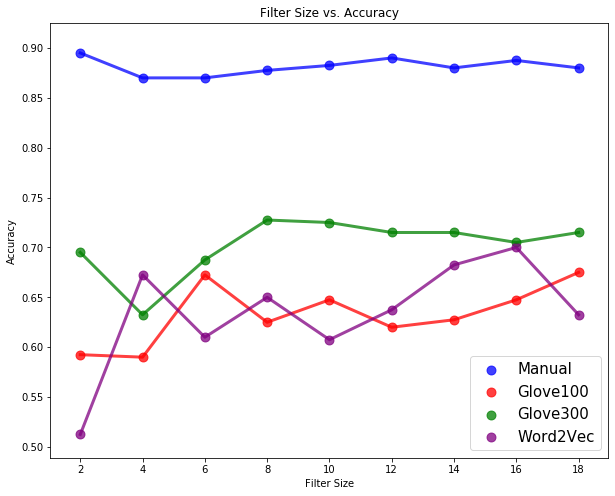

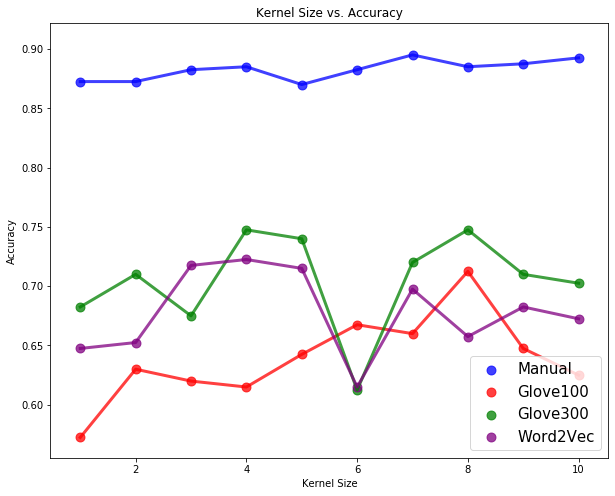

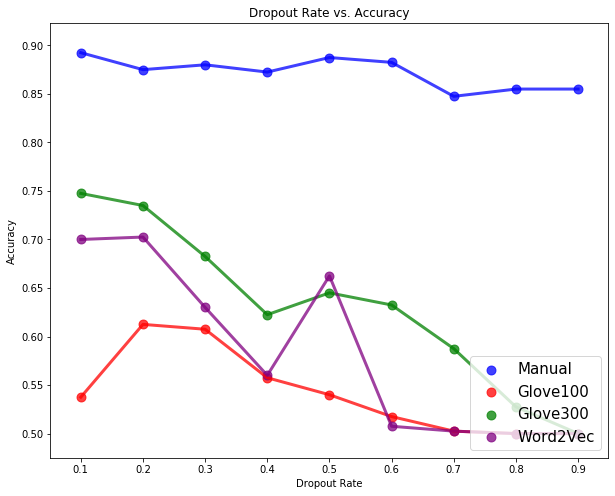

In [44]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(filter_data_manual[:, 0], filter_data_manual[:, 1], s=80, color='blue', alpha=0.75, label='Manual')
ax.plot(filter_data_manual[:, 0], filter_data_manual[:, 1], lw=3, color='blue', alpha=0.75)

ax.scatter(filter_data_g100[:, 0], filter_data_g100[:, 1], s=80, color='red', alpha=0.75, label='Glove100')
ax.plot(filter_data_g100[:, 0], filter_data_g100[:, 1], lw=3, color='red', alpha=0.75)

ax.scatter(filter_data_g300[:, 0], filter_data_g300[:, 1], s=80, color='green', alpha=0.75, label='Glove300')
ax.plot(filter_data_g300[:, 0], filter_data_g300[:, 1], lw=3, color='green', alpha=0.75)

ax.scatter(filter_data_w2v[:, 0], filter_data_w2v[:, 1], s=80, color='purple', alpha=0.75, label='Word2Vec')
ax.plot(filter_data_w2v[:, 0], filter_data_w2v[:, 1], lw=3, color='purple', alpha=0.75)

ax.legend(fontsize=15, loc=4)
plt.title("Filter Size vs. Accuracy")
plt.xlabel("Filter Size")
plt.ylabel("Accuracy")
plt.show()

f, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(kernel_data_manual[:, 0], kernel_data_manual[:, 1], s=80, color='blue', alpha=0.75, label='Manual')
ax.plot(kernel_data_manual[:, 0], kernel_data_manual[:, 1], lw=3, color='blue', alpha=0.75)

ax.scatter(kernel_data_g100[:, 0], kernel_data_g100[:, 1], s=80, color='red', alpha=0.75, label='Glove100')
ax.plot(kernel_data_g100[:, 0], kernel_data_g100[:, 1], lw=3, color='red', alpha=0.75)

ax.scatter(kernel_data_g300[:, 0], kernel_data_g300[:, 1], s=80, color='green', alpha=0.75, label='Glove300')
ax.plot(kernel_data_g300[:, 0], kernel_data_g300[:, 1], lw=3, color='green', alpha=0.75)

ax.scatter(kernel_data_w2v[:, 0], kernel_data_w2v[:, 1], s=80, color='purple', alpha=0.75, label='Word2Vec')
ax.plot(kernel_data_w2v[:, 0], kernel_data_w2v[:, 1], lw=3, color='purple', alpha=0.75)

ax.legend(fontsize=15, loc=4)
plt.title("Kernel Size vs. Accuracy")
plt.xlabel("Kernel Size")
plt.ylabel("Accuracy")
plt.show()

f, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(dropout_data_manual[:, 0], dropout_data_manual[:, 1], s=80, color='blue', alpha=0.75, label='Manual')
ax.plot(dropout_data_manual[:, 0], dropout_data_manual[:, 1], lw=3, color='blue', alpha=0.75)

ax.scatter(dropout_data_g100[:, 0], dropout_data_g100[:, 1], s=80, color='red', alpha=0.75, label='Glove100')
ax.plot(dropout_data_g100[:, 0], dropout_data_g100[:, 1], lw=3, color='red', alpha=0.75)

ax.scatter(dropout_data_g300[:, 0], dropout_data_g300[:, 1], s=80, color='green', alpha=0.75, label='Glove300')
ax.plot(dropout_data_g300[:, 0], dropout_data_g300[:, 1], lw=3, color='green', alpha=0.75)

ax.scatter(dropout_data_w2v[:, 0], dropout_data_w2v[:, 1], s=80, color='purple', alpha=0.75, label='Word2Vec')
ax.plot(dropout_data_w2v[:, 0], dropout_data_w2v[:, 1], lw=3, color='purple', alpha=0.75)
ax.legend(fontsize=15, loc=4)
plt.title("Dropout Rate vs. Accuracy")
plt.xlabel("Dropout Rate")
plt.ylabel("Accuracy")
plt.show()

## Create Final Model and Test Predictions

In [64]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=encoder.vocab_size, 
                                    output_dim=embedding_dim, 
                                    weights=[weights_manual],
                                    mask_zero=True,
                                    trainable=False))

model.add(tf.keras.layers.Conv1D(filters=64,
                          kernel_size=5,
                          activation='relu',
                                ))

model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dropout(rate=0))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))


# Compile and train model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_data, epochs=8, validation_data=test_data)
eval_loss, eval_acc = model.evaluate(test_data)

Epoch 1/8
320/320 [==============================] - 4s 12ms/step - loss: 0.2559 - accuracy: 0.8481 - val_loss: 0.3012 - val_accuracy: 0.8725
Epoch 2/8
320/320 [==============================] - 3s 11ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.3515 - val_accuracy: 0.8850
Epoch 3/8
320/320 [==============================] - 5s 14ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.3553 - val_accuracy: 0.8775
Epoch 4/8
320/320 [==============================] - 4s 12ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3777 - val_accuracy: 0.8675
Epoch 5/8
320/320 [==============================] - 4s 12ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4096 - val_accuracy: 0.8825
Epoch 6/8
320/320 [==============================] - 3s 11ms/step - loss: 9.9151e-04 - accuracy: 1.0000 - val_loss: 0.4329 - val_accuracy: 0.8875
Epoch 7/8
320/320 [==============================] - 4s 11ms/step - loss: 6.1050e-04 - accuracy: 1.0000 - val_loss: 0.4231 - val_accuracy: 0.880

In [69]:
pos_review = "This movie is a gosh darn masterpiece. It will make you belly laugh, \
            it will chill you to the bone, and it will make you shed a tear. This \
            movie will stay with you long after the credits are over. If you plan \
            on watching this movie, AVOID SPOILERS AT ALL COSTS."

neg_review_1 = "Saving Christmas needed saving...and by that, I mean it should have \
been mercy killed. the acting is horrendous and it's story is only a reminder that \
anyone that paid to see it wasted their money. Even if you are a die-hard Christian, \
please do not see this movie, it's one of the worst movies you could ever watch ever, \
and considering stuff like The Room and Birdemic exists, That's saying A lot. oh, and \
that thing Kirk Cameron's doing to try to boost the rating on Rotten Tomatoes: Cameron,\
you should know the Bible verse 'Thou shalt not bear false witness' it's one of the 10 \
commandments. That's all I have to say on this matter, Don't watch the film. I mean \
Seriously Cameron, you should know better."

neg_review_2 = "There is no script. Action poor. Acting Poor. A strict no! Pleas save \
find your money on this one! I wouldn't even rate if possible. Worst ever music! No heads \
or tails!"


In [70]:
for review in [(pos_review, 1), (neg_review_1, 0),(neg_review_2, 0)]:
    print("Review:",review[0])
    print("Class:", review[1])
    
    encoded = encoder.encode(review[0])
    print("Encoded:", encoded)
    
    print("Prediction:", model.predict_classes([encoded]))
    print("----------")
   

Review: This movie is a gosh darn masterpiece. It will make you belly laugh,             it will chill you to the bone, and it will make you shed a tear. This             movie will stay with you long after the credits are over. If you plan             on watching this movie, AVOID SPOILERS AT ALL COSTS.
Class: 1
Encoded: [39697, 14014, 28913, 8788, 19554, 1755, 5936, 39697, 32104, 36822, 13064, 1716, 18719, 5728, 32104, 24034, 13064, 34999, 38259, 38304, 24622, 5728, 32104, 36822, 13064, 12488, 8788, 14836, 39697, 14014, 32104, 37353, 25148, 13064, 1708, 33278, 38259, 11774, 8305, 26809, 39697, 13064, 2779, 24639, 8878, 30350, 14014, 39697, 39697, 39697, 39697, 39697]
Prediction: [[1]]
----------
Review: Saving Christmas needed saving...and by that, I mean it should have been mercy killed. the acting is horrendous and it's story is only a reminder that anyone that paid to see it wasted their money. Even if you are a die-hard Christian, please do not see this movie, it's one of the wor